In [488]:
%matplotlib inline

import json
import datetime
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model, ensemble, svm, feature_selection, decomposition

sys.path.append("../")
import utils.load_data as ld
import utils.transformations as tf
import utils.machine_learning as ml

In [189]:
%load_ext autoreload
%autoreload 2

## import

get greatest market losses over the next 1, 3 and 6 months for each date

In [177]:
market = ld.latest_csv_to_pandas('market')
market.columns = ['dow', 's&p', 'nasdaq']

In [178]:
market.head()

,dow,s&p,nasdaq
Date,,,
1970-01-02,NaN,93.000000,NaN
1970-01-05,NaN,93.459999,NaN
1970-01-06,NaN,92.820000,NaN
1970-01-07,NaN,92.629997,NaN
1970-01-08,NaN,92.680000,NaN


In [179]:
# create df of lagged returns
ticker = 's&p'
px = pd.DataFrame(data=market[ticker].values, 
                  columns=[0,], 
                  index=market[ticker].index)
for i in range(1, 180):
    px[i] = px[0].shift(-1 * i)
ret = (px.div(px[0], axis='index')
       .applymap(lambda x: x - 1.))

In [180]:
# build df of max losses over multiple ranges
losses = {}
for months in (1,3,6):
    per = 22 * months 
    losses[months] = pd.Series(data=[tf.get_max_loss(per, ret.ix[i:,:]) for i in range(0,ret.shape[0]-per)],
                              index=ret.index[:ret.shape[0]-per])
losses = pd.DataFrame(losses)

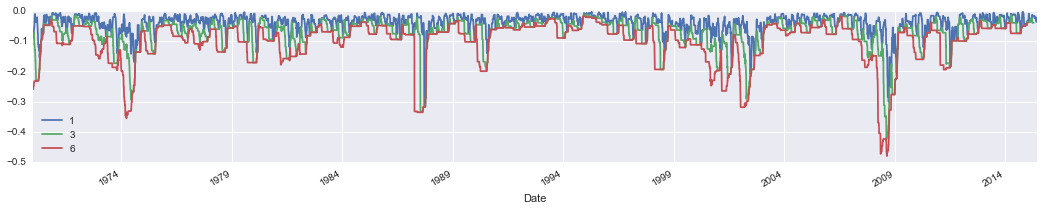

In [181]:
losses.plot(figsize=[18,3])

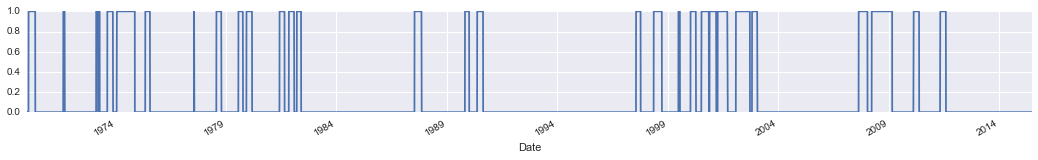

In [182]:
losses = tf.classify_losses(losses, loss_threshold=-.1, period=3)
losses.plot(figsize=[18,2])

import FRED data

In [183]:
fred = ld.latest_csv_to_pandas('fred')

In [184]:
fred.head()

,GDP,CPIAUCSL,CPILFESL,VIXCLS,VXVCLS,AAA,DTB3,TOTDTEUSQ163N,GFDEGDQ188S,EXHOSLUSM495S,LES1252881600Q
DATE,,,,,,,,,,,
1970-01-01,1053.5,37.9,39.6,NaN,NaN,7.91,NaN,NaN,35.31153,NaN,NaN
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,7.92,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,7.91,NaN,NaN,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,7.93,NaN,NaN,NaN,NaN
1970-01-07,NaN,NaN,NaN,NaN,NaN,NaN,7.90,NaN,NaN,NaN,NaN


import scraped multipl data

In [185]:
multipl = ld.latest_multipl_json_to_pandas()

In [186]:
multipl.head()

title,1 Month Treasury Rate,1 Year Treasury Rate,10 Year Real Interest Rate,10 Year Treasury Rate,12 month EPS,2 Year Treasury Rate,20 Year Real Interest Rate,20 Year Treasury Rate,3 Month Treasury Rate,3 Year Treasury Rate,...,US Inflation Rate,US Labor Force Participation Rate,US Long Term Unemployment Rate,US Median Income Growth Rate,US Median Real Income Growth,US Real GDP Growth Rate,US Real Income Per Capita Growth Rate,US Real Retail Sales,US Real Retail Sales Growth,US Retail Sales Growth
date,,,,,,,,,,,,,,,,,,,,,
1871-01-01 00:00:00,NaN,NaN,NaN,0.0532,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-01-31 00:00:00,NaN,NaN,NaN,NaN,0.0763,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-02-01 00:00:00,NaN,NaN,NaN,0.0532,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-02-28 00:00:00,NaN,NaN,NaN,NaN,0.0741,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-03-01 00:00:00,NaN,NaN,NaN,0.0533,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## consolidate

In [187]:
start = datetime.datetime(1970, 1, 1)
def generalize(df):
    df = df.resample('d', fill_method='ffill')
    df.index.name = 'date'
    df = df.ix[start:]
    return df
market = generalize(market)
fred = generalize(fred)
multipl = generalize(multipl)
frames = [market, fred, multipl]
ag = pd.concat(frames, axis=1)

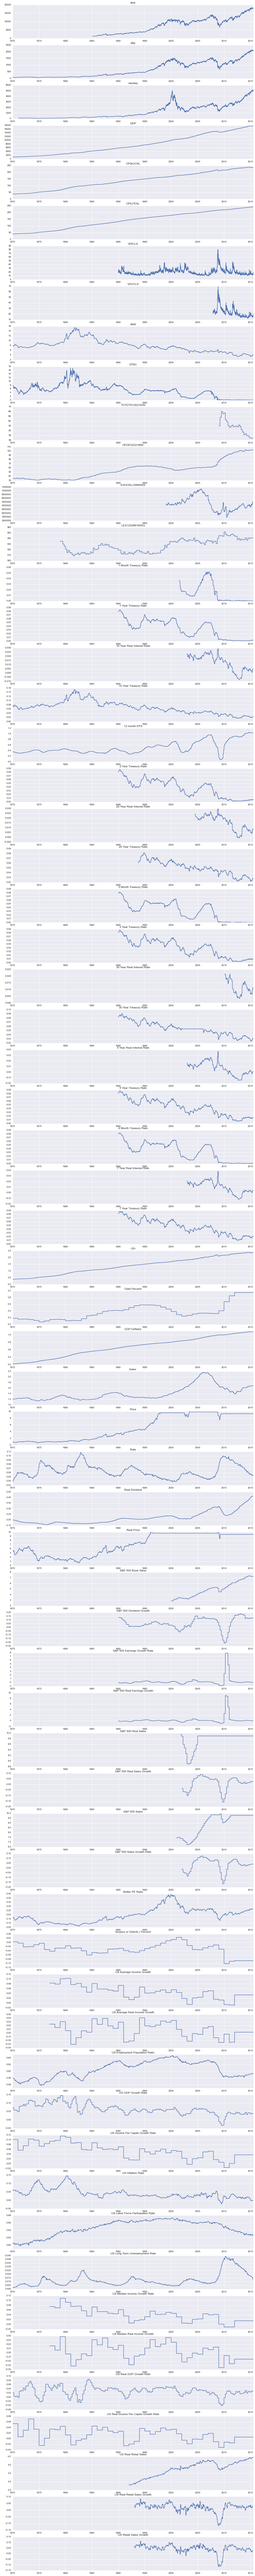

In [188]:
# plot each series
count = len(ag.columns)
fig, axes = plt.subplots(nrows=count, figsize=[18, count * 3])
for ind in range(count):
    (ag[ag.columns[ind]].plot(title=ag.columns[ind],
                              ax=axes[ind])
     .set_xlabel(""))

## test various models on training data

create new dataframe with columns in levels, change, or standard deviation space

In [190]:
# build features using every available column and transformation
# skip column if doesn't have data available at start date
start = datetime.datetime(1970, 1, 1)
features = pd.DataFrame()
for c in ag.columns:
    if not pd.isnull(ag.ix[ag.index == start][c].values[0]):
        features['{0} level'.format(c)] = ag[c]
        for y in (.125, .25, .5, 1, 2, 5,):
            features['{0} change {1} years'.format(c, y)] = tf.change_space(ag[c], y)
            features['{0} std {1} years'.format(c, y)] = tf.std_space(ag[c], y)   
features.head()   

,GDP level,GDP change 0.125 years,GDP std 0.125 years,GDP change 0.25 years,GDP std 0.25 years,GDP change 0.5 years,GDP std 0.5 years,GDP change 1 years,GDP std 1 years,GDP change 2 years,...,US Real Income Per Capita Growth Rate change 0.25 years,US Real Income Per Capita Growth Rate std 0.25 years,US Real Income Per Capita Growth Rate change 0.5 years,US Real Income Per Capita Growth Rate std 0.5 years,US Real Income Per Capita Growth Rate change 1 years,US Real Income Per Capita Growth Rate std 1 years,US Real Income Per Capita Growth Rate change 2 years,US Real Income Per Capita Growth Rate std 2 years,US Real Income Per Capita Growth Rate change 5 years,US Real Income Per Capita Growth Rate std 5 years
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,1053.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-02,1053.5,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1970-01-03,1053.5,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1970-01-04,1053.5,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1970-01-05,1053.5,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0


In [527]:
# time series score
avg = pd.ewma(features, halflife=360*10, min_periods=360*2)
std = pd.ewmstd(features, halflife=360*10, min_periods=360*2)
scores = (((features - avg) / std)
          .dropna(axis=0, how='any'))

### feature selection

In [528]:
# remove bad features with obviously outlying data
high_scores = scores.applymap(lambda x: abs(x)).max()
outliers = high_scores[high_scores > 5].index.values
scores = scores.drop(outliers, axis=1)

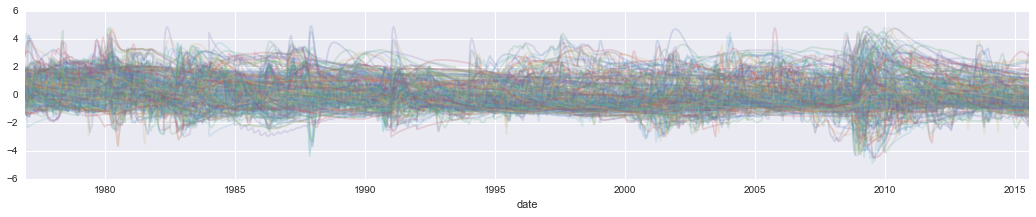

In [529]:
scores.plot(figsize=[18,3], alpha=.2, legend=False)

pick top performers in univariate space wiht boosted hit data

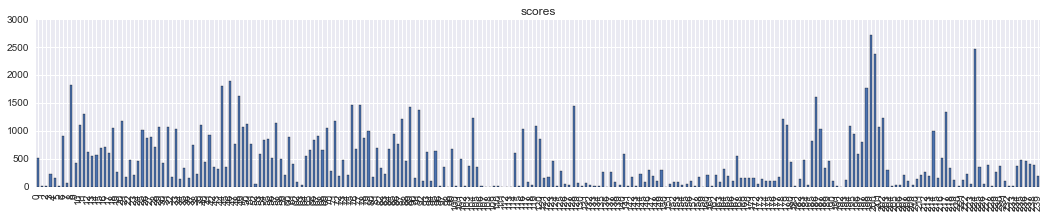

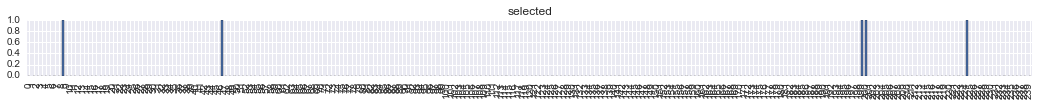

In [530]:
X_train, X_test, y_train, y_test = ml.gen_Xs_ys_split(scores, losses)
X_train_up, y_train_up = ml.upsample_hits(X_train, y_train)
univariate_fit = feature_selection.SelectKBest(feature_selection.f_classif, k=5).fit(X_train_up, y_train_up)
selected_features = X_train.columns[univariate_fit.get_support()]
pd.DataFrame(univariate_fit.scores_).plot(kind='bar', figsize=[18,3], legend=False, title="scores")
pd.DataFrame(univariate_fit.get_support()).plot(kind='bar', figsize=[18,1], legend=False, title="selected")

plot performance of selected features and show scatter of 2d pca to judge whether hits are cornered

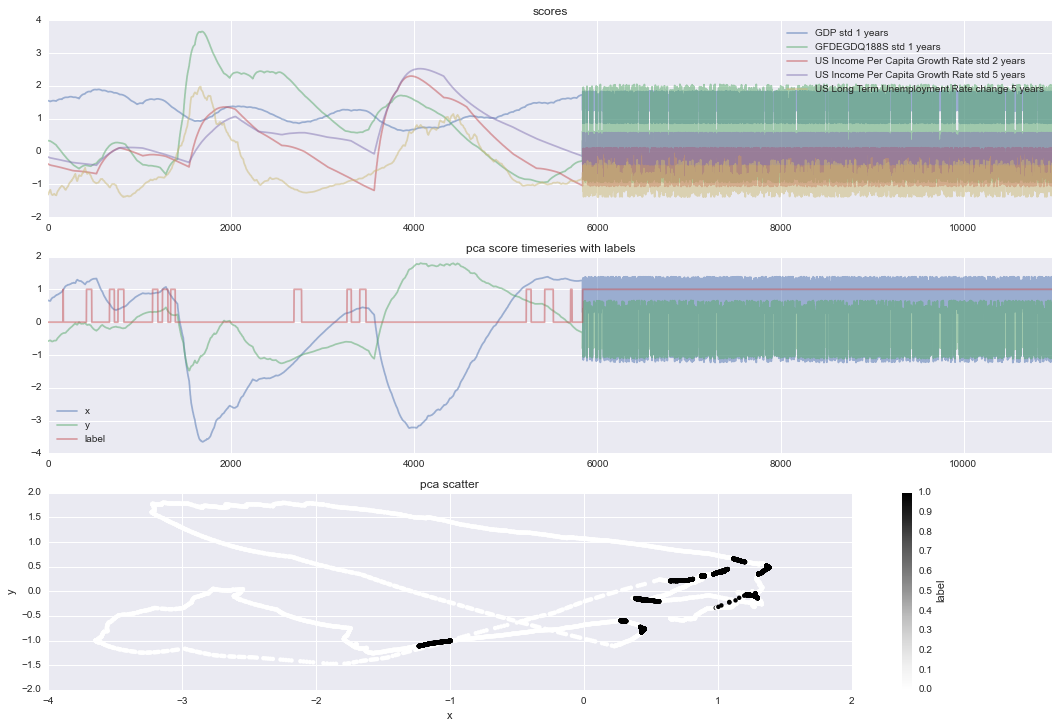

In [531]:
fig, axes = plt.subplots(nrows=3, figsize=[18, 12])

X_train_up = X_train_up[selected_features]

X_train_up.plot(title="scores", ax=axes[0], alpha=.5)

pca = decomposition.PCA()
pca.n_components = 2

X_train_reduced = pca.fit_transform(X_train_up)
z = np.append(X_train_reduced, np.vstack(y_train_up.values), 1)
z = pd.DataFrame(data=z, columns=['x', 'y', 'label'])
z.plot(alpha=.5, ax=axes[1], title="pca score timeseries with labels")
z.plot(kind='scatter', x='x', y='y', c='label', edgecolors='none', title="pca scatter", ax=axes[2])

### run models

regenerate X and ys without upsampling and toss out unselected features

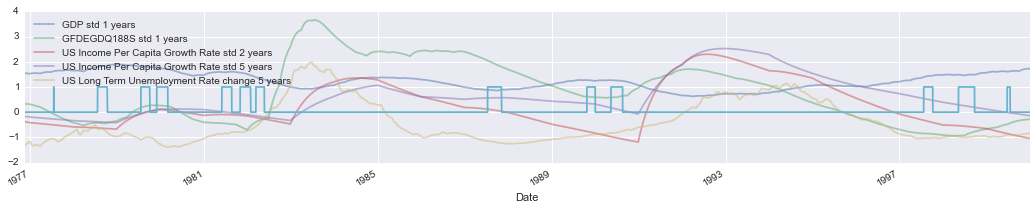

In [532]:
X_train, X_test, y_train, y_test = ml.gen_Xs_ys_split(scores, losses)
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_train.plot(figsize=[18,3], alpha=.5)
y_train.plot()

run grid search on logistic regression

In [533]:
grid = ml.run_grid_search(linear_model.LogisticRegression, 
                          X_train,
                          y_train,
                          C=[.001, .01, .1, 1, 10], 
                          penalty=['l1', 'l2'])
grid

,C,geometric_mean,metric_mean,penalty,weighted_accuracy
0,0.001,0.333384,0.439229,l1,0.545075
1,0.001,0.370980,0.466297,l2,0.561615
2,0.010,0.437737,0.504646,l1,0.571556
3,0.010,0.416490,0.495678,l2,0.574866
4,0.100,0.220360,0.415567,l1,0.610775
5,0.100,0.223898,0.402950,l2,0.582002
6,1.000,0.167721,0.388425,l1,0.609130
7,1.000,0.198345,0.400289,l2,0.602234
8,10.000,0.165678,0.384450,l1,0.603222
9,10.000,0.163719,0.380841,l2,0.597963


pick best model and plot learning curve and time series decisions

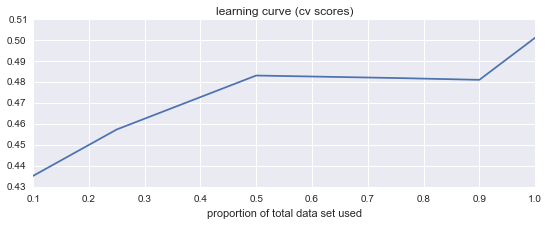

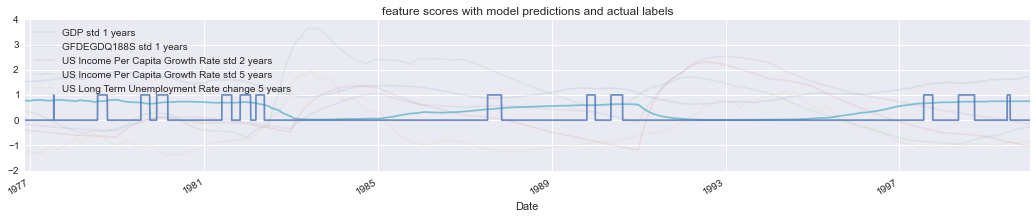

In [538]:
clf = linear_model.LogisticRegression(penalty="l1", C=.01)
ml.plot_learning_curve(clf, X_train, y_train)
ml.plot_decisions_on_train_set(clf, X_train, y_train)

run grid search on random forest classifier

In [539]:
grid = ml.run_grid_search(ensemble.RandomForestClassifier, 
                          X_train,
                          y_train,
                          n_estimators=[1, 3, 10, 50, 200],
                          max_features=[1, 2, None],
                          max_depth=[1, 2, None])
grid

,geometric_mean,max_depth,max_features,metric_mean,n_estimators,weighted_accuracy
0,0.671144,1,1,0.642938,1,0.614732
1,0.450012,1,1,0.507214,3,0.564415
2,0.459359,1,1,0.528015,10,0.596671
3,0.400629,1,1,0.494128,50,0.587628
4,0.400629,1,1,0.494128,200,0.587628
5,0.445178,1,2,0.482088,1,0.518998
6,0.471758,1,2,0.541376,3,0.610994
7,0.413527,1,2,0.496379,10,0.579232
8,0.361142,1,2,0.466071,50,0.571000
9,0.413527,1,2,0.496379,200,0.579232


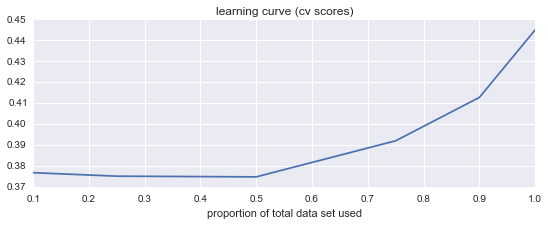

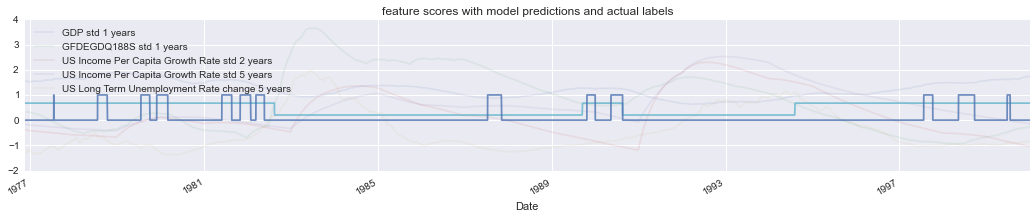

In [540]:
clf = ensemble.RandomForestClassifier(n_estimators=1, max_depth=1, max_features=1)
ml.plot_learning_curve(clf, X_train, y_train)
ml.plot_decisions_on_train_set(clf, X_train, y_train)

gradient boosting classifier

In [541]:
grid = ml.run_grid_search(ensemble.GradientBoostingClassifier, 
                          X_train,
                          y_train,
                          n_estimators=[1, 3, 10, 50, 200, 300, 400],
                          learning_rate=[.001, .01, .1, 1, 10])
grid

,geometric_mean,learning_rate,metric_mean,n_estimators,weighted_accuracy
0,0.000000,0.001,0.125000,1,0.250000
1,0.000000,0.001,0.125000,3,0.250000
2,0.000000,0.001,0.125000,10,0.250000
3,0.084654,0.001,0.172857,50,0.261059
4,0.335966,0.001,0.413375,200,0.490785
5,0.352115,0.001,0.428506,300,0.504898
6,0.352115,0.001,0.428506,400,0.504898
7,0.000000,0.010,0.125000,1,0.250000
8,0.000000,0.010,0.125000,3,0.250000
9,0.335966,0.010,0.413375,10,0.490785


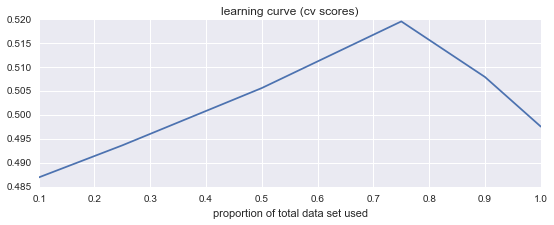

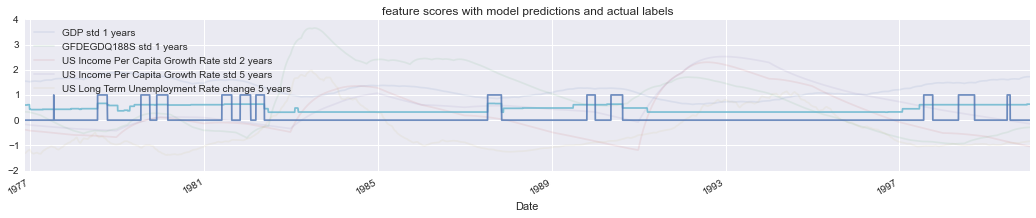

In [542]:
clf = ensemble.GradientBoostingClassifier(n_estimators=50, learning_rate=.01)
ml.plot_learning_curve(clf, X_train, y_train)
ml.plot_decisions_on_train_set(clf, X_train, y_train)

##test selected model on test data

In [ ]:
clf = ensemble.GradientBoostingClassifier(n_estimators=200, learning_rate=.01)
ml.test_model(clf, X_train, X_test, y_train, y_test)

In [ ]:
X_test.plot(figsize=[18,3], alpha=.1, title="feature scores with model predictions and actual labels")
pd.Series(clf.predict_proba(X_test)[:,1], index=X_test.index).plot(alpha=.8)
y_test.plot(alpha=.8)